In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier

## 🍷 Load the Wine Dataset

In [3]:
wine = datasets.load_wine()
X, y = wine.data, wine.target

###  Train/Test Split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(124, 13) (54, 13) (124,) (54,)


## ⚙️ Building a Custom Decision Tree Classifier

### Steps to Build the Tree

1. **Initialize the tree**  
   - Start with the full dataset at the root node. 🌱

2. 🔄 **Repeat for each node**  
   For each node:

   - **Find the best split**  
     - Evaluate all features and possible threshold values.
     - For each possible split, calculate the **Gini impurity** and the **information gain**. 
     - The **split with the highest information gain** (or lowest Gini impurity) is chosen.

   - ⏸️ **Check stopping conditions**  
     - Stop the tree growth if one of the following conditions is met:
       - The maximum depth is reached. 
       - The node has fewer than the minimum number of samples. 
       - No further significant improvement (gain) can be made. 

   - ✂️ **Split the dataset**  
     - Divide the data into two groups (left and right) based on the chosen feature and threshold. Each group will form a child node. 

3. ✅ **Make predictions after tree is built**  
   - For each sample, start at the root and traverse the tree according to the feature values. 
   - The class label of the leaf node is the predicted class for the sample. 


In [ ]:
class CustomDecisionTree:
    def __init__(self, max_depth=5, min_samples=3, min_gain=1e-3):
        self.max_depth = max_depth
        self.min_samples = min_samples
        self.min_gain = min_gain
        self.tree = None

    def gini(self, y):
        if len(y) == 0: return 0
        probs = [(y == c).mean() for c in np.unique(y)]
        return 1 - sum(p**2 for p in probs)

    def information_gain(self, parent, left, right):
        total = len(parent)
        return self.gini(parent) - (len(left)/total * self.gini(left)) - (len(right)/total * self.gini(right))

    def find_best_split(self, X, y, idxs):
        best_feat, best_thresh, best_gain = None, None, 0
        for f in range(X.shape[1]):
            vals = np.unique(X[idxs, f])
            for i in range(len(vals) - 1):
                t = (vals[i] + vals[i + 1]) / 2
                left = [j for j in idxs if X[j, f] <= t]
                right = [j for j in idxs if X[j, f] > t]
                if len(left) < self.min_samples or len(right) < self.min_samples:
                    continue
                gain = self.information_gain(y[idxs], y[left], y[right])
                if gain > best_gain:
                    best_feat, best_thresh, best_gain = f, t, gain
        if best_gain < self.min_gain:
            return None, None
        return best_feat, best_thresh

    def build_tree(self, X, y, idxs, depth):
        labels = y[idxs]
        if depth == self.max_depth or len(np.unique(labels)) == 1 or len(idxs) < self.min_samples:
            return np.bincount(labels).argmax()
        feat, thresh = self.find_best_split(X, y, idxs)
        if feat is None:
            return np.bincount(labels).argmax()
        left = [i for i in idxs if X[i, feat] <= thresh]
        right = [i for i in idxs if X[i, feat] > thresh]
        return {
            'feature': feat,
            'threshold': thresh,
            'left': self.build_tree(X, y, left, depth + 1),
            'right': self.build_tree(X, y, right, depth + 1),
        }

    def fit(self, X, y):
        self.tree = self.build_tree(X, y, list(range(len(X))), 0)

    def predict_one(self, x, node):
        if not isinstance(node, dict):
            return node
        if x[node['feature']] <= node['threshold']:
            return self.predict_one(x, node['left'])
        return self.predict_one(x, node['right'])

    def predict(self, X):
        return np.array([self.predict_one(x, self.tree) for x in X])


### 🚀 Train & Compare the Models

In [143]:
custom_tree = CustomDecisionTree()
custom_tree.fit(X_train, y_train)
y_pred_custom = custom_tree.predict(X_test)

In [144]:
sklearn_tree = DecisionTreeClassifier()
sklearn_tree.fit(X_train, y_train)
y_pred_sk = sklearn_tree.predict(X_test)

### Accuracy Comparison

In [ ]:
print("Tuned Custom Tree Accuracy:    ", accuracy_score(y_test, y_pred_custom))
print("Scikit-learn Tree Accuracy:     ", accuracy_score(y_test, y_pred_sk))

Tuned Custom Tree Accuracy:     0.9629629629629629
Scikit‑learn Tree Accuracy:      0.9444444444444444


## Visualize the Custom Tree

In [ ]:
def plot_custom_tree(node, feature_names, class_names, X, y, indices=None,
                     pos=(0.5, 1), ax=None, width=1.0, vert_gap=0.3):
    if ax is None:
        fig, ax = plt.subplots(figsize=(14, 8))
        ax.axis('off')
        indices = list(range(len(X)))

    if isinstance(node, dict):  
        feat = node['feature']
        thresh = node['threshold']
        feat_name = feature_names[feat]

        left_idx = [i for i in indices if X[i, feat] <= thresh]
        right_idx = [i for i in indices if X[i, feat] > thresh]
        labels = y[indices]
        gini = custom_tree.gini(labels)
        counts = np.bincount(labels, minlength=len(class_names))
        majority = np.argmax(counts)

        ax.text(pos[0], pos[1],
                f"{feat_name} <= {thresh:.2f}\ngini = {gini:.3f}\nsamples = {len(labels)}\n"
                f"value = {counts.tolist()}\nclass = {class_names[majority]}",
                ha='center', va='center',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='lightblue', edgecolor='black'),
                fontsize=9)

        dx = width / 2
        dy = vert_gap
        left_pos = (pos[0] - dx, pos[1] - dy)
        right_pos = (pos[0] + dx, pos[1] - dy)
        ax.plot([pos[0], left_pos[0]], [pos[1], left_pos[1]], 'k-')
        ax.plot([pos[0], right_pos[0]], [pos[1], right_pos[1]], 'k-')

        plot_custom_tree(node['left'], feature_names, class_names, X, y, left_idx, left_pos, ax, width / 2, vert_gap)
        plot_custom_tree(node['right'], feature_names, class_names, X, y, right_idx, right_pos, ax, width / 2, vert_gap)

    else:  
        labels = y[indices]
        counts = np.bincount(labels, minlength=len(class_names))
        ax.text(pos[0], pos[1],
                f"class = {class_names[node]}\nsamples = {len(labels)}\nvalue = {counts.tolist()}",
                ha='center', va='center',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgreen', edgecolor='black'),
                fontsize=9)
    return ax


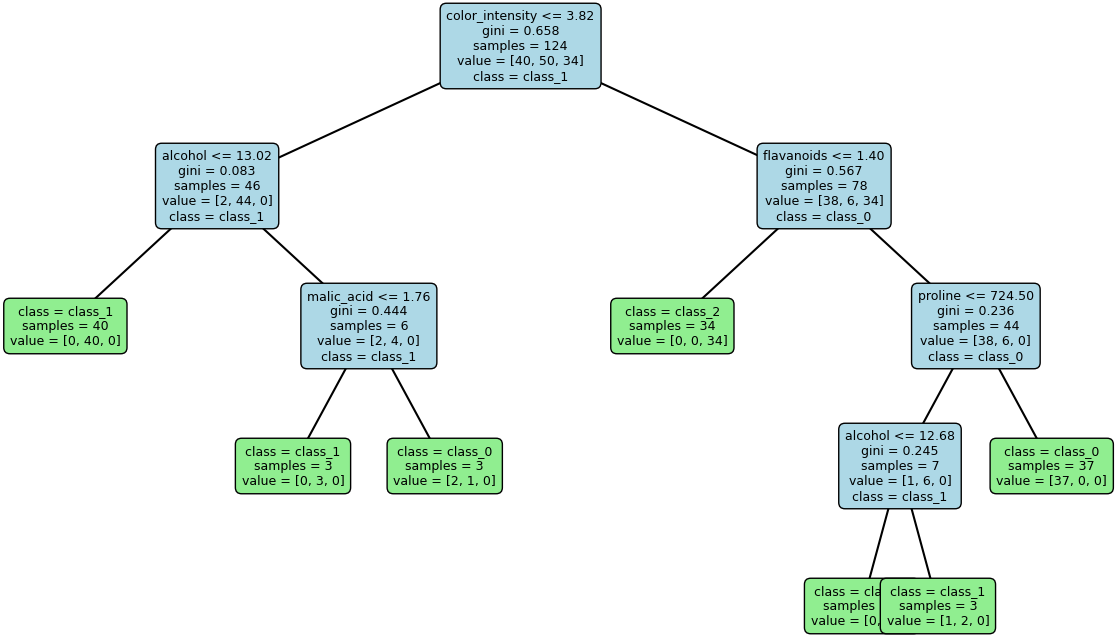

In [147]:
plot_custom_tree(custom_tree.tree, wine.feature_names, wine.target_names, X_train, y_train)
plt.show()

##  Visualize Scikit-learn Tree

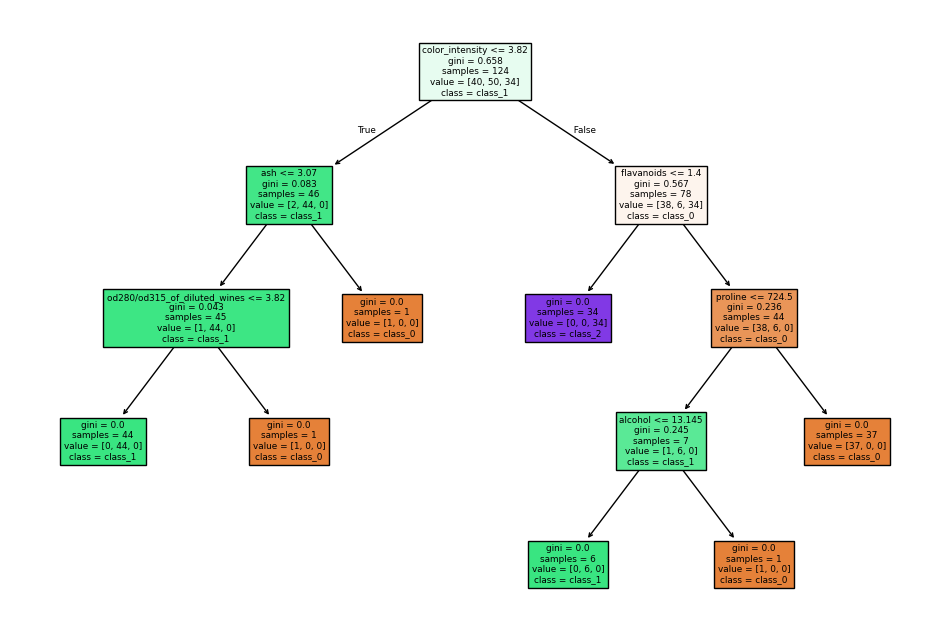

In [148]:
plt.figure(figsize=(12, 8))
plot_tree(sklearn_tree, feature_names=wine.feature_names,
             class_names=wine.target_names, filled=True)
plt.show()